In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

##### Utility Functions

In [2]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total

def cornell_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_infections(sim_df)
    return total

def cornell_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_hosp(sim_df)
    return total

In [3]:
def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(112)
    inf_list = list()
    hosp_list = list()
    for group in sim.sims:
        df = group.sim_df
        inf_list.append(get_cum_infections(df))
        hosp_list.append(get_cum_hosp(df))
    return inf_list, hosp_list

def run_multiple_trajectories(sim, T, n):
    inf_matrix = list()
    hosp_matrix = list()
    for _ in range(n):
        result = run_multigroup_sim(sim, T)
        inf_matrix.append(result[0])
        hosp_matrix.append(result[1])
    return inf_matrix, hosp_matrix

In [4]:
def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n):
    assert len(params_list) == len(test_frac)
    
    group_size = list()
    tests_per_day = 0
    
    # set group based contacts per day, test frequency
    for index, params in enumerate(params_list):
        params['expected_contacts_per_day'] = interaction_matrix[index, index]
        params['test_population_fraction'] = test_frac[index]
        group_size.append(params['population_size'])
        tests_per_day += group_size[-1] * test_frac[index]
    
    assert len(group_size) == len(test_frac)
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
    inf_matrix, hosp_matrix = run_multiple_trajectories(sim, T, n)
    return tests_per_day, inf_matrix, hosp_matrix

In [5]:
def generate_plotting_matrix(results_list, policy=None, ):
    daily_tests = list()
    inf = list()
    inf_low = list()
    inf_high = list()
    hosp = list()
    hosp_low = list()
    hosp_high = list()
    cornell_inf = list()
    cornell_inf_low = list()
    cornell_inf_high = list()
    cornell_hosp = list()
    cornell_hosp_low = list()
    cornell_hosp_high = list()
    ithaca_inf = list()
    
    ithaca_inf_low = list()
    ithaca_inf_high = list()
    ithaca_hosp = list()
    ithaca_hosp_low = list()
    ithaca_hosp_high = list()


#     policy_ug_off_campus_unmonitored = list()
#     policy_ug_off_campus_compliant = list()
#     policy_grad_research = list()
#     policy_grad_other_unmonitored = list()
#     policy_grad_other_compliant = list()
#     policy_staff_student = list()
#     policy_staff_non_student = list()
#     policy_staff_off_campus = list()
    
    policies = list()
    
    for policy_dict in results_list:
        daily_tests.append(policy_dict['tests_per_day'])
        inf.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.5, axis=0))
        inf_low.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.1, axis=0))
        inf_high.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.9, axis=0))
        hosp.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.5, axis=0))
        hosp_low.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.1, axis=0))
        hosp_high.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.9, axis=0))
        
       

        cornell_inf.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.5, axis=0))
        cornell_inf_low.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.1, axis=0))
        cornell_inf_high.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.9, axis=0))
        cornell_hosp.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.5, axis=0))
        cornell_hosp_low.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.1, axis=0))
        cornell_hosp_high.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.9, axis=0))
        
        
        
        ithaca_inf.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,-1][:,None], axis=1), 0.5, axis=0))
        ithaca_inf_low.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,-1][:,None], axis=1), 0.1, axis=0))
        ithaca_inf_high.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,-1][:,None], axis=1), 0.9, axis=0))
        ithaca_hosp.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,-1][:,None], axis=1), 0.5, axis=0))
        ithaca_hosp_low.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,-1][:,None], axis=1), 0.1, axis=0))
        ithaca_hosp_high.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,-1][:,None], axis=1), 0.9, axis=0))
        
#         policy_ug_off_campus_unmonitored.append(int(policy_dict['test_policy'][0]*7))
#         policy_ug_off_campus_compliant.append(int(policy_dict['test_policy'][1]*7))
#         policy_grad_research.append(int(policy_dict['test_policy'][2]*7))
#         policy_grad_other_unmonitored.append(int(policy_dict['test_policy'][3]*7))
#         policy_grad_other_compliant.append(int(policy_dict['test_policy'][4]*7))
#         policy_staff_student.append(int(policy_dict['test_policy'][5]*7))
#         policy_staff_non_student.append(int(policy_dict['test_policy'][6]*7))
#         policy_staff_off_campus.append(policy_dict['test_policy'][7]*7)
              
        if policy != None:
            test_policy_string = '['
            for frequency in policy_dict['test_policy'][:-2]:
                test_policy_string += str(int(frequency * 7)) + ','
            test_policy_string += str(np.round(policy[-2] * 7, 2))
            test_policy_string += ']'
            policies.append(test_policy_string)
        else:
            policies.append(None)
                
    plotting_data = pd.DataFrame({'daily_tests': daily_tests, 'inf': inf, 'inf_low': inf_low, 'inf_high': inf_high, 'hosp': hosp,
                  'hosp_low': hosp_low, 'hosp_high': hosp_high, 'cornell_inf': cornell_inf, 'cornell_inf_low': cornell_inf_low,
                  'cornell_inf_high': cornell_inf_high, 'cornell_hosp': cornell_hosp, 'cornell_hosp_low': cornell_hosp_low,
                  'cornell_hosp_high': cornell_hosp_high,'ithaca_inf': ithaca_inf, 'ithaca_inf_low': ithaca_inf_low,
                  'ithaca_inf_high': ithaca_inf_high, 'ithaca_hosp': ithaca_hosp, 'ithaca_hosp_low': ithaca_hosp_low,
                  'ithaca_hosp_high': ithaca_hosp_high,
                                  
#                   'test_policy_ug_off_campus_unmonitored': policy_ug_off_campus_unmonitored,
#                   'test_policy_ug_off_campus_compliant': policy_ug_off_campus_compliant,               
#                   'test_policy_grad_research': policy_grad_research, 
#                   'test_policy_grad_other_unmonitored': policy_grad_other_unmonitored,
#                   'test_policy_grad_other_compliant': policy_grad_other_compliant,               
#                   'test_policy_staff_student': policy_staff_student,
#                   'test_policy_staff_non_student': policy_staff_non_student,
#                   'test_policy_staff_off_campus': policy_staff_off_campus,
                  'test_policy': policies})

    
    plotting_data['inf_yerr_low'] = plotting_data['inf'] - plotting_data['inf_low']
    plotting_data['inf_yerr_high'] = plotting_data['inf_high'] - plotting_data['inf']
    plotting_data['hosp_yerr_low'] = plotting_data['hosp'] - plotting_data['hosp_low']
    plotting_data['hosp_yerr_high'] = plotting_data['hosp_high'] - plotting_data['hosp']
    
    plotting_data['cornell_inf_yerr_low'] = plotting_data['cornell_inf'] - plotting_data['cornell_inf_low']
    plotting_data['cornell_inf_yerr_high'] = plotting_data['cornell_inf_high'] - plotting_data['cornell_inf']
    plotting_data['cornell_hosp_yerr_low'] = plotting_data['cornell_hosp'] - plotting_data['cornell_hosp_low']
    plotting_data['cornell_hosp_yerr_high'] = plotting_data['cornell_hosp_high'] - plotting_data['cornell_hosp']
    
    plotting_data['ithaca_inf_yerr_low'] = plotting_data['ithaca_inf'] - plotting_data['ithaca_inf_low']
    plotting_data['ithaca_inf_yerr_high'] = plotting_data['ithaca_inf_high'] - plotting_data['ithaca_inf']
    plotting_data['ithaca_hosp_yerr_low'] = plotting_data['ithaca_hosp'] - plotting_data['ithaca_hosp_low']
    plotting_data['ithaca_hosp_yerr_high'] = plotting_data['ithaca_hosp_high'] - plotting_data['ithaca_hosp']
    
    return plotting_data

## Nominal

In [6]:
def get_nominal_params():
    base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/nominal/'
    
    ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
    ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
    gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
    gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
    faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
    faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
    faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
    ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

    interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                                   [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                                   [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                                   [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                                   [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                                   [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                                   [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                                   [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

    group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']
    
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    return params_list, interaction_matrix, group_names

###### The cells below are where the above function code was copied from

In [ ]:
# base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/nominal/'

# ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
# ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
# gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
# gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
# faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
# faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
# faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
# ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

In [ ]:
# interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
#                                [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
#                                [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
#                                [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
#                                [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
#                                [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
#                                [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
#                                [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

# group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [ ]:
# params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
# tests_per_day_nominal, sim_results_nominal = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 112, 50)

## Optimistic

In [7]:
def get_optimistic_params():
    base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/optimistic/'

    ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
    ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
    gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
    gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
    faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
    faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
    faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
    ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]
    
    interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                                   [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                                   [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                                   [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                                   [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                                   [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                                   [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                                   [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

    group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']
    
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    
    return params_list, 0.7*interaction_matrix, group_names

###### The cells below are where the above function code was copied from

In [ ]:
# base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/optimistic/'

# ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
# ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
# gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
# gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
# faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
# faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
# faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
# ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

In [ ]:
# interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
#                                [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
#                                [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
#                                [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
#                                [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
#                                [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
#                                [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
#                                [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

# group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [ ]:
# params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
# tests_per_day_optimistic, sim_results_optimistic = evaluate_testing_policy(params_list, 0.7*interaction_matrix, group_names, policy, 112, 50)

## Pessimistic

In [8]:
def get_pessimistic_params():
    base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/pessimistic/'

    ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
    ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
    gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
    gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
    faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
    faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
    faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
    ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]
    
    interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                                   [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                                   [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                                   [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                                   [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                                   [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                                   [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                                   [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

    group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']
    
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    
    return params_list, 1.3*interaction_matrix, group_names

###### The cells below are where the above function code was copied from

In [ ]:
# base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/pessimistic/'

# ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
# ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
# gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
# gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
# faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
# faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
# faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
# ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

In [ ]:
# interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
#                                [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
#                                [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
#                                [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
#                                [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
#                                [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
#                                [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
#                                [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

# group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [ ]:
# params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
# tests_per_day_pessimistic, sim_results_pessimistic = evaluate_testing_policy(params_list, 1.3*interaction_matrix, group_names, policy, 112, 50)

# Figure 2 (Cornell, Ithaca infections / hospitalizations under virtual and in-person and with reduced compliance) 

### Generating Residential Instruction data

In [37]:
np.random.seed(2022)
testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

inperson_normal = list()
print('Evaluating this policy: ', testing_policy)

params_list, interaction_matrix, group_names = get_nominal_params()

tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 100)
inperson_normal.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]


In [38]:
plotting_data_inperson_normal = generate_plotting_matrix(inperson_normal, testing_policy)

### Generating Residential Instruction (less compliant) data

In [39]:
testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

inperson_less_compliant = list()
print('Evaluating this policy: ', testing_policy)

params_list, interaction_matrix, group_names = get_nominal_params()

interaction_matrix = np.array([[15.1788,4.8572,0.1,0.1,1,0.05,0.05,0.1],
                               [4.14,9.7144,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,10.9287,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 100)
inperson_less_compliant.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]


In [40]:
plotting_data_inperson_less_compliant = generate_plotting_matrix(inperson_less_compliant, testing_policy)

### Generating Virtual Instruction data
##### Use v2 below

In [41]:
gs_research_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/grad_research_virtual.yaml')[1]
faculty_staff_student_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/faculty_staff_student_same_age_virtual.yaml')[1]
faculty_staff_non_student_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/faculty_staff_non_student_same_age_virtual.yaml')[1]
faculty_staff_off_campus_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/faculty_staff_off_campus_same_age_virtual.yaml')[1]
ithaca_community_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/ithaca_community_virtual.yaml')[1]

ug_off_campus_unmonitored_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/ug_off_campus_unmonitored_virtual.yaml')[1]
ug_off_campus_compliant_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/ug_off_campus_compliant_virtual.yaml')[1]
gs_other_unmonitored_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/grad_other_unmonitored_virtual.yaml')[1]
gs_other_compliant_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/grad_other_compliant_virtual.yaml')[1]

In [42]:
# 1/5 students are monitored. Adjust param files manually
total_ug_pop = ug_off_campus_unmonitored_params['population_size'] + ug_off_campus_compliant_params['population_size']
ug_off_campus_unmonitored_params['population_size'] = np.ceil(0.8 * total_ug_pop)
ug_off_campus_compliant_params['population_size'] = np.floor(0.2 * total_ug_pop)

In [43]:
testing_policy = [0, 2/7,1/7,0,2/7, 2/7,1/7,1/30, 0]

interaction_matrix = np.array([[8.8651, 2.2163, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                [8.8651, 2.2163, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                [0.17, 0.0435, 4, 0.1, 0.1, 1.2, 0.05, 0.2, 1.8],
                                [0.19, 0.05, 0.11, 6.9926, 1.7482, 0.05, 0.05, 0.05, 1],
                                [0.19, 0.05, 0.11, 6.9926, 1.7482, 0.05, 0.05, 0.05, 1],
                                [0.04, 0.01, 0.53, 0.02, 0.00, 1, 0.15, 0.3, 1.56],
                                [0.07, 0.02, 0.04, 0.03, 0.01, 0.28, 1.8, 0.2, 1.56],
                                [0.03, 0.01, 0.07, 0.01, 0.00, 0.23, 0.08, 1.8, 1.56],
                                [0.045, 0.011, 0.046, 0.034, 0.008, 0.091, 0.048, 0.12, 3.5]
                               ])

virtual_normal = list()

print('Evaluating this policy: ', testing_policy)
params_list = [ug_off_campus_unmonitored_params.copy(), ug_off_campus_compliant_params.copy(), gs_research_params.copy(), gs_other_unmonitored_params.copy(), gs_other_compliant_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 50)
virtual_normal.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0, 0.2857142857142857, 0.14285714285714285, 0, 0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]


In [44]:
plotting_data_virtual_normal = generate_plotting_matrix(virtual_normal, testing_policy)

### Generating Virtual Instruction data (v2)

In [71]:
gs_research_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/grad_research_virtual.yaml')[1]
faculty_staff_student_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/faculty_staff_student_same_age_virtual.yaml')[1]
faculty_staff_non_student_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/faculty_staff_non_student_same_age_virtual.yaml')[1]
faculty_staff_off_campus_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/faculty_staff_off_campus_same_age_virtual.yaml')[1]
ithaca_community_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/ithaca_community_virtual.yaml')[1]

ug_off_campus_unmonitored_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/ug_off_campus_unmonitored_virtual.yaml')[1]
ug_off_campus_compliant_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/ug_off_campus_compliant_virtual.yaml')[1]
gs_other_unmonitored_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/grad_other_unmonitored_virtual.yaml')[1]
gs_other_compliant_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/grad_other_compliant_virtual.yaml')[1]

In [72]:
# 1/5 students are monitored. Adjust param files manually
total_ug_pop = ug_off_campus_unmonitored_params['population_size'] + ug_off_campus_compliant_params['population_size']
perc_ug_compliant = ug_off_campus_compliant_params['population_size'] / total_ug_pop
total_gs_pop = gs_other_unmonitored_params['population_size'] + gs_other_compliant_params['population_size']
perc_gs_compliant = gs_other_compliant_params['population_size'] / total_gs_pop

In [73]:
testing_policy = [2/7 * perc_ug_compliant, 1/7, 1/7 * perc_gs_compliant, 2/7, 1/7, 1/30, 0]

params_list, interaction_matrix, group_names = get_nominal_params()

interaction_matrix = np.array([[11.41 * 0.9712,0.1,0.1,1,0.05,0.05,0.2],
                               [0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.17,0.07,9 * 0.9712,1,0.05,0.05,0.2],
                               [2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

group_sizes = [3468, 1594, 1434, 3598, 1907, 4778, 62000]
params_list = params_list[1:]
group_names = group_names[1:]

# Rescale bottom triangle
for i in range(interaction_matrix.shape[0]):
    for j in range(i):
        interaction_matrix[i,j] = interaction_matrix[j,i] * group_sizes[j] / group_sizes[i]

virtual_normal = list()

print('Evaluating this policy: ', testing_policy)
# params_list = [ug_off_campus_unmonitored_params.copy(), ug_off_campus_compliant_params.copy(), gs_research_params.copy(), gs_other_unmonitored_params.copy(), gs_other_compliant_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 100)
virtual_normal.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]


In [79]:
plotting_data_virtual_normal = generate_plotting_matrix(virtual_normal, testing_policy)

### Generating Virtual Instruction (less compliant) data
##### Use v2 below

In [45]:
testing_policy = [0, 2/7,1/7,0,2/7, 2/7,1/7,1/30, 0]

interaction_matrix = np.array([[9.7022, 2.4255, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                [9.7022, 2.4255, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                [0.17, 0.0435, 4, 0.1, 0.1, 1.2, 0.05, 0.2, 1.8],
                                [0.19, 0.05, 0.11, 7.6529, 1.9132, 0.05, 0.05, 0.05, 1],
                                [0.19, 0.05, 0.11, 7.6529, 1.9132, 0.05, 0.05, 0.05, 1],
                                [0.04, 0.01, 0.53, 0.02, 0.00, 1, 0.15, 0.3, 1.56],
                                [0.07, 0.02, 0.04, 0.03, 0.01, 0.28, 1.8, 0.2, 1.56],
                                [0.03, 0.01, 0.07, 0.01, 0.00, 0.23, 0.08, 1.8, 1.56],
                                [0.045, 0.011, 0.046, 0.034, 0.008, 0.091, 0.048, 0.12, 3.5]
                               ])

virtual_less_compliant = list()

print('Evaluating this policy: ', testing_policy)
params_list = [ug_off_campus_unmonitored_params.copy(), ug_off_campus_compliant_params.copy(), gs_research_params.copy(), gs_other_unmonitored_params.copy(), gs_other_compliant_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 50)
virtual_less_compliant.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0, 0.2857142857142857, 0.14285714285714285, 0, 0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]


In [46]:
plotting_data_virtual_less_compliant = generate_plotting_matrix(virtual_less_compliant, testing_policy)

### Generating Virtual Instruction (less compliant) v2 data

In [80]:
testing_policy = [2/7 * perc_ug_compliant, 1/7, 1/7 * perc_gs_compliant, 2/7, 1/7, 1/30, 0]

params_list, interaction_matrix, group_names = get_nominal_params()

interaction_matrix = np.array([[11.41 * 0.9712 * (1-0.075)/(1-0.15),0.1,0.1,1,0.05,0.05,0.2],
                               [0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.17,0.07,9 * 0.9712 * (1-0.075)/(1-0.15),1,0.05,0.05,0.2],
                               [2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

group_sizes = [3468, 1594, 1434, 3598, 1907, 4778, 62000]
params_list = params_list[1:]
group_names = group_names[1:]

# Rescale bottom triangle
for i in range(interaction_matrix.shape[0]):
    for j in range(i):
        interaction_matrix[i,j] = interaction_matrix[j,i] * group_sizes[j] / group_sizes[i]

virtual_less_compliant = list()

print('Evaluating this policy: ', testing_policy)
# params_list = [ug_off_campus_unmonitored_params.copy(), ug_off_campus_compliant_params.copy(), gs_research_params.copy(), gs_other_unmonitored_params.copy(), gs_other_compliant_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 100)
virtual_less_compliant.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]


In [81]:
plotting_data_virtual_less_compliant = generate_plotting_matrix(virtual_less_compliant, testing_policy)

### Plotting

In [82]:
plotting_data_virtual_normal['name'] = 'Virtual'
plotting_data_virtual_less_compliant['name'] = 'Virtual, less compliant'
plotting_data_inperson_normal['name'] = 'Residential'
plotting_data_inperson_less_compliant['name'] = 'Residential, less compliant'

(0, 15)

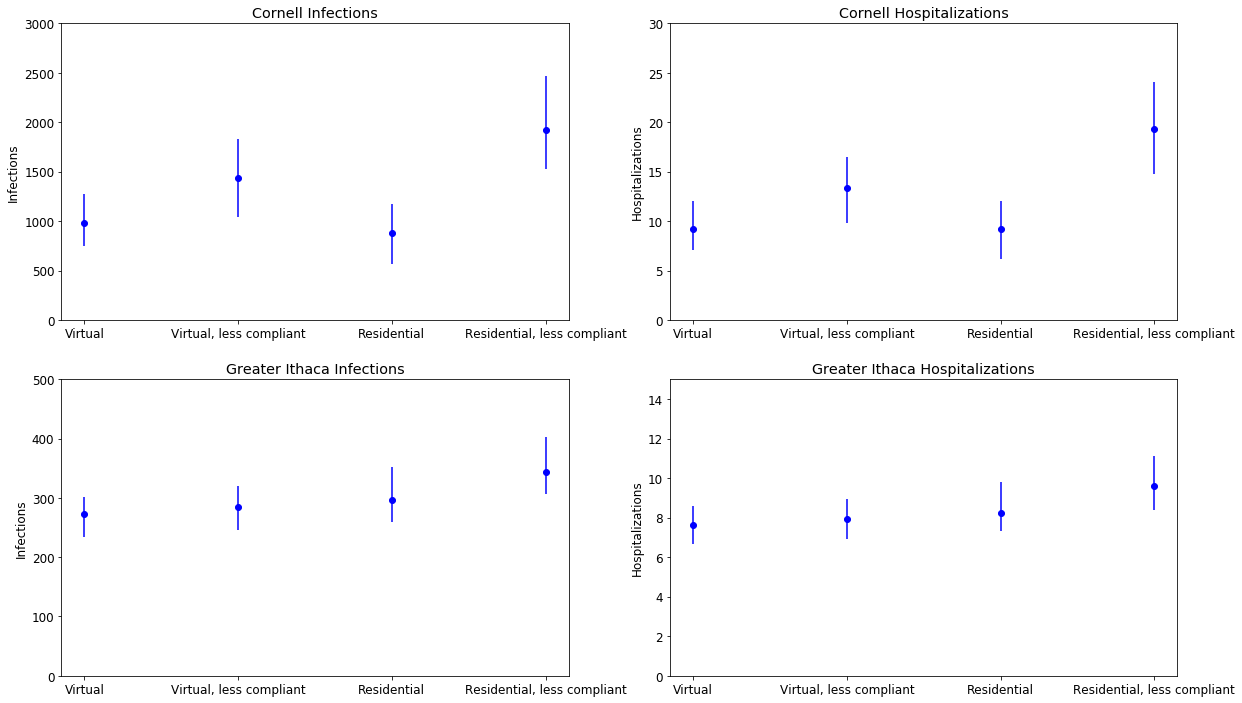

In [84]:
# fig = plt.figure(figsize=(20,12))
# ax = fig.add_subplot(111)

f, axs = plt.subplots(2,2,sharex=True,figsize=(20,12))

plt.subplot(2, 2, 1)
plt.errorbar(x='name', y='cornell_inf', yerr = [plotting_data_virtual_normal['cornell_inf_yerr_low'],plotting_data_virtual_normal['cornell_inf_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_normal)
plt.errorbar(x='name', y='cornell_inf', yerr = [plotting_data_virtual_less_compliant['cornell_inf_yerr_low'],plotting_data_virtual_less_compliant['cornell_inf_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_less_compliant)
plt.errorbar(x='name', y='cornell_inf', yerr = [plotting_data_inperson_normal['cornell_inf_yerr_low'],plotting_data_inperson_normal['cornell_inf_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_normal)
plt.errorbar(x='name', y='cornell_inf', yerr = [plotting_data_inperson_less_compliant['cornell_inf_yerr_low'],plotting_data_inperson_less_compliant['cornell_inf_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_less_compliant)

plt.title('Cornell Infections')
plt.ylabel('Infections')
# plt.xlabel('Scenarios')
plt.ylim(0, 3000)
# plt.show()


# fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(111)

plt.subplot(2, 2, 2)
plt.errorbar(x='name', y='cornell_hosp', yerr = [plotting_data_virtual_normal['cornell_hosp_yerr_low'],plotting_data_virtual_normal['cornell_hosp_yerr_high']], fmt='o', color='b', data=plotting_data_virtual_normal)
plt.errorbar(x='name', y='cornell_hosp', yerr = [plotting_data_virtual_less_compliant['cornell_hosp_yerr_low'],plotting_data_virtual_less_compliant['cornell_hosp_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_less_compliant)
plt.errorbar(x='name', y='cornell_hosp', yerr = [plotting_data_inperson_normal['cornell_hosp_yerr_low'],plotting_data_inperson_normal['cornell_hosp_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_normal)
plt.errorbar(x='name', y='cornell_hosp', yerr = [plotting_data_inperson_less_compliant['cornell_hosp_yerr_low'],plotting_data_inperson_less_compliant['cornell_hosp_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_less_compliant)

plt.title('Cornell Hospitalizations')
plt.ylabel('Hospitalizations')
# plt.xlabel('Scenarios')
plt.ylim(0, 30)
# plt.show()



# fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(111)

plt.subplot(2, 2, 3)
plt.errorbar(x='name', y='ithaca_inf', yerr = [plotting_data_virtual_normal['ithaca_inf_yerr_low'],plotting_data_virtual_normal['ithaca_inf_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_normal)
plt.errorbar(x='name', y='ithaca_inf', yerr = [plotting_data_virtual_less_compliant['ithaca_inf_yerr_low'],plotting_data_virtual_less_compliant['ithaca_inf_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_less_compliant)
plt.errorbar(x='name', y='ithaca_inf', yerr = [plotting_data_inperson_normal['ithaca_inf_yerr_low'],plotting_data_inperson_normal['ithaca_inf_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_normal)
plt.errorbar(x='name', y='ithaca_inf', yerr = [plotting_data_inperson_less_compliant['ithaca_inf_yerr_low'],plotting_data_inperson_less_compliant['ithaca_inf_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_less_compliant)

plt.title('Greater Ithaca Infections')
plt.ylabel('Infections')
# plt.xlabel('Scenarios')
plt.ylim(0, 500)
# plt.show()


# fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(111)

plt.subplot(2, 2, 4)
plt.errorbar(x='name', y='ithaca_hosp', yerr = [plotting_data_virtual_normal['ithaca_hosp_yerr_low'],plotting_data_virtual_normal['ithaca_hosp_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_normal)
plt.errorbar(x='name', y='ithaca_hosp', yerr = [plotting_data_virtual_less_compliant['ithaca_hosp_yerr_low'],plotting_data_virtual_less_compliant['ithaca_hosp_yerr_high']], fmt='o', color='b',data=plotting_data_virtual_less_compliant)
plt.errorbar(x='name', y='ithaca_hosp', yerr = [plotting_data_inperson_normal['ithaca_hosp_yerr_low'],plotting_data_inperson_normal['ithaca_hosp_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_normal)
plt.errorbar(x='name', y='ithaca_hosp', yerr = [plotting_data_inperson_less_compliant['ithaca_hosp_yerr_low'],plotting_data_inperson_less_compliant['ithaca_hosp_yerr_high']], fmt='o', color='b',data=plotting_data_inperson_less_compliant)

plt.title('Greater Ithaca Hospitalizations')
plt.ylabel('Hospitalizations')
# plt.xlabel('Scenarios')
plt.ylim(0, 15)
# plt.show()

# plt.savefig('res_inst_paper_graphs/virtual_residential_comp.jpg', dpi=450)

# Figure 3 - Contour Plot (# students, daily test frequency), for virtual instruction

In [9]:
np.random.seed(2023)

In [10]:
gs_research_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/grad_research_virtual.yaml')[1]
faculty_staff_student_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/faculty_staff_student_same_age_virtual.yaml')[1]
faculty_staff_non_student_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/faculty_staff_non_student_same_age_virtual.yaml')[1]
faculty_staff_off_campus_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/faculty_staff_off_campus_same_age_virtual.yaml')[1]
ithaca_community_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/ithaca_community_virtual.yaml')[1]

ug_off_campus_unmonitored_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/ug_off_campus_unmonitored_virtual.yaml')[1]
ug_off_campus_compliant_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/ug_off_campus_compliant_virtual.yaml')[1]
gs_other_unmonitored_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/grad_other_unmonitored_virtual.yaml')[1]
gs_other_compliant_params = load_params('../src/simulations_v2/params/baseline_testing/virtual_instruction/grad_other_compliant_virtual.yaml')[1]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [11]:
# 1/5 students are monitored. Adjust param files manually
total_ug_pop = ug_off_campus_unmonitored_params['population_size'] + ug_off_campus_compliant_params['population_size']
ug_off_campus_unmonitored_params['population_size'] = np.ceil(0.8 * total_ug_pop)
ug_off_campus_compliant_params['population_size'] = np.floor(0.2 * total_ug_pop)

In [12]:
def rescale_virtual_interaction_matrix(perc_ug_compliant, group_sizes):
    interaction_matrix = np.array([[8.8651, 2.2163, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                    [8.8651, 2.2163, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                    [0.17, 0.0435, 4, 0.1, 0.1, 1.2, 0.05, 0.2, 1.8],
                                    [0.19, 0.05, 0.11, 6.9926, 1.7482, 0.05, 0.05, 0.05, 1],
                                    [0.19, 0.05, 0.11, 6.9926, 1.7482, 0.05, 0.05, 0.05, 1],
                                    [0.04, 0.01, 0.53, 0.02, 0.00, 1, 0.15, 0.3, 1.56],
                                    [0.07, 0.02, 0.04, 0.03, 0.01, 0.28, 1.8, 0.2, 1.56],
                                    [0.03, 0.01, 0.07, 0.01, 0.00, 0.23, 0.08, 1.8, 1.56],
                                    [0.045, 0.011, 0.046, 0.034, 0.008, 0.091, 0.048, 0.12, 3.5]
                                   ])
    interaction_matrix[0,0] = (8.8651 + 2.2163) * (1 - perc_ug_compliant)
    interaction_matrix[0,1] = (8.8651 + 2.2163) * (perc_ug_compliant)
    interaction_matrix[1,1] = (8.8651 + 2.2163) * (perc_ug_compliant)
    for i in range(interaction_matrix.shape[0]):
        for j in range(i):
            if ((i,j) == (0,0)) or ((i,j)==(0,1)) or ((i,j)==(1,1)):
                continue
            interaction_matrix[i,j] = interaction_matrix[j,i] * group_sizes[j] / group_sizes[i]
    return interaction_matrix

In [13]:
virtual_group_sizes = [ug_off_campus_unmonitored_params['population_size'], ug_off_campus_compliant_params['population_size'], gs_research_params['population_size'], gs_other_unmonitored_params['population_size'], gs_other_compliant_params['population_size'], faculty_staff_student_params['population_size'], faculty_staff_non_student_params['population_size'], faculty_staff_off_campus_params['population_size'], ithaca_community_params['population_size']]
virtual_group_sizes

[5549.0, 1387.0, 1594, 1434, 1434, 3598, 1907, 4778, 62000]

In [ ]:
X_popsize = [3000, 4000, 5000, 6000, 7000, 8000, 9000]
Y_compliant = [0.01, 0.1, 0.2, 0.3, 0.4]

Zs_hosp = []
Zs_inf = []
Zs_cornell_hosp = []
Zs_cornell_inf = []
Zs_UG_hosp = []
Zs_UG_inf = []

for popsize in X_popsize:
    
    Z_hosp = []
    Z_inf = []
    Z_cornell_hosp = []
    Z_cornell_inf = []
    Z_UG_hosp = []
    Z_UG_inf = []
    for perc_compliant in Y_compliant:
#for (contacts, popsize), dfs in sensitivity_output.sim_results['Nominal Student Parameters'].items():
        testing_policy = [0, 2/7,1/7,0,2/7, 2/7,1/7,1/30, 0]

        params_list = [ug_off_campus_unmonitored_params.copy(), ug_off_campus_compliant_params.copy(), gs_research_params.copy(), gs_other_unmonitored_params.copy(), gs_other_compliant_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]

        group_names = ['UG unmonitored', 'UG compliant', 'GS research', 'GS compliant', 'GS monitored', 'F/S student', 'F/S non-student', 'F/S off', 'Ithaca']
        
        group_sizes = virtual_group_sizes.copy()
        group_sizes[0] = int(np.ceil(popsize * (1 - perc_compliant)))
        group_sizes[1] = int(np.floor(popsize * perc_compliant))
        
        params_list[0]['population_size'] = group_sizes[0]
        params_list[1]['population_size'] = group_sizes[1]

        # rescale interaction matrix based on population sizes
        interaction_matrix = rescale_virtual_interaction_matrix(perc_compliant, group_sizes)
        
        virtual_normal = list()
        
        print('Evaluating this: ', popsize, perc_compliant)
        tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 50)

        virtual_normal.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})        
        
        Z_hosp.append(np.quantile(np.sum(hosp_matrix, axis=1), 0.5))
        Z_inf.append(np.quantile(np.sum(inf_matrix, axis=1), 0.5))
        Z_cornell_hosp.append(np.quantile(np.sum(np.array(hosp_matrix)[:,:-1],axis=1), 0.5))
        Z_cornell_inf.append(np.quantile(np.sum(np.array(inf_matrix)[:,:-1],axis=1), 0.5))
        Z_UG_hosp.append(np.quantile(np.sum(np.array(hosp_matrix)[:,:2],axis=1), 0.5))
        Z_UG_inf.append(np.quantile(np.sum(np.array(inf_matrix)[:,:2],axis=1), 0.5))        

    Zs_hosp.append(Z_hosp)
    Zs_inf.append(Z_inf)
    Zs_cornell_hosp.append(Z_cornell_hosp)
    Zs_cornell_inf.append(Z_cornell_inf)
    Zs_UG_hosp.append(Zs_UG_hosp)
    Zs_UG_inf.append(Zs_UG_inf)

Evaluating this:  3000 0.01
Evaluating this:  3000 0.1
Evaluating this:  3000 0.2
Evaluating this:  3000 0.3
Evaluating this:  3000 0.4
Evaluating this:  4000 0.01
Evaluating this:  4000 0.1
Evaluating this:  4000 0.2
Evaluating this:  4000 0.3
Evaluating this:  4000 0.4
Evaluating this:  5000 0.01
Evaluating this:  5000 0.1
Evaluating this:  5000 0.2


In [ ]:
f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))

# inf_levels = [0.025, 0.05, 0.1, 0.2, 0.3, 0.5]
# inf_labels = dict()
# for level in inf_levels:
#     inf_labels[level] = str(level*100) + '%'
    
plt.subplot(1,2,1)
plt.title("Cumulative Infections (Cornell)")
plt.ylabel("Percent Compliant")
plt.xlabel("Undergraduates Returning")
CS = plt.contour(np.array(X_popsize), np.array(Y_compliant), np.array(Zs_UG_inf).T)
# CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_inf).T/34310, inf_levels)
# plt.clabel(CS, fmt=inf_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)


plt.subplot(1,2,2)
plt.title("Cumulative Hospitalizations (Cornell)")
plt.ylabel("Percent Compliant")
plt.xlabel("Undergraduates Returning")
CS = plt.contour(np.array(X_popsize), np.array(Y_compliant), np.array(Zs_UG_hosp).T)
# pop_levels = [0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]
# pop_labels = dict()
# for level in pop_levels:
#     pop_labels[level] = str(level*100) + '%'
# CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_hosp).T/34310, pop_levels)
# plt.clabel(CS, fmt=pop_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)
plt.show()


# plt.savefig('res_inst_paper_graphs/test_freq_tr_mult_contour.jpg', dpi=450)

In [ ]:
Zs_UG_inf

# Figure 3 v2 (modeling non-compliance as a reduction in daily test frequency)

# Figure 4 - Sensitivity Analysis (initial prevalence, transmission rate mult, cases found per contact tracing)

In [138]:
np.random.seed(2024)
# params_list, interaction_matrix, group_names = get_nominal_params()

### Initial Prevalence

In [ ]:
initial_prevalence_mult_list = [0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4]

nominal_results = list()
optimistic_results = list()
pessimistic_results = list()

testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

for initial_prevalence_mult in initial_prevalence_mult_list:
    print('Evaluating this mult: ', initial_prevalence_mult)
    nominal_params_list, nominal_interaction_matrix, group_names = get_nominal_params()
    optimistic_params_list, optimistic_interaction_matrix, group_names = get_optimistic_params()
    pessimistic_params_list, pessimistic_interaction_matrix, group_names = get_pessimistic_params()
    for param_config in nominal_params_list:
        param_config['initial_ID_prevalence'] *= initial_prevalence_mult
    for param_config in optimistic_params_list:
        param_config['initial_ID_prevalence'] *= initial_prevalence_mult
    for param_config in pessimistic_params_list:
        param_config['initial_ID_prevalence'] *= initial_prevalence_mult

#     params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    nominal_tests_per_day, nominal_inf_matrix, nominal_hosp_matrix = evaluate_testing_policy(nominal_params_list, nominal_interaction_matrix, group_names, testing_policy, 112, 100)
    nominal_results.append({'test_policy': policy, 'tests_per_day': nominal_tests_per_day, 'inf_matrix': nominal_inf_matrix, 'hosp_matrix': nominal_hosp_matrix})
    optimistic_tests_per_day, optimistic_inf_matrix, optimistic_hosp_matrix = evaluate_testing_policy(optimistic_params_list, optimistic_interaction_matrix, group_names, testing_policy, 112, 100)
    optimistic_results.append({'test_policy': policy, 'tests_per_day': optimistic_tests_per_day, 'inf_matrix': optimistic_inf_matrix, 'hosp_matrix': optimistic_hosp_matrix})
    pessimistic_tests_per_day, pessimistic_inf_matrix, pessimistic_hosp_matrix = evaluate_testing_policy(pessimistic_params_list, pessimistic_interaction_matrix, group_names, testing_policy, 112, 100)
    pessimistic_results.append({'test_policy': policy, 'tests_per_day': pessimistic_tests_per_day, 'inf_matrix': pessimistic_inf_matrix, 'hosp_matrix': pessimistic_hosp_matrix})


Evaluating this mult:  0.5


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Evaluating this mult:  0.75
Evaluating this mult:  1
Evaluating this mult:  1.5
Evaluating this mult:  2


In [ ]:
plotting_data_nominal_results = generate_plotting_matrix(nominal_results)
plotting_data_nominal_results['initial_prev_mult'] = initial_prevalence_mult_list
plotting_data_optimistic_results = generate_plotting_matrix(optimistic_results)
plotting_data_optimistic_results['initial_prev_mult'] = initial_prevalence_mult_list
plotting_data_pessimistic_results = generate_plotting_matrix(pessimistic_results)
plotting_data_pessimistic_results['initial_prev_mult'] = initial_prevalence_mult_list


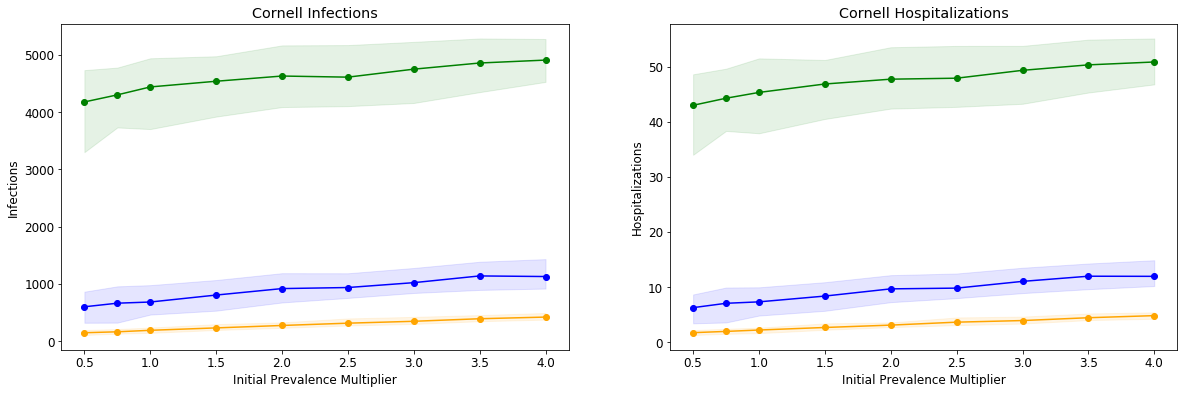

<Figure size 432x288 with 0 Axes>

In [159]:
f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))

plt.subplot(1, 2, 1)
plt.plot(plotting_data_nominal_results[['initial_prev_mult']], plotting_data_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='initial_prev_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_optimistic_results[['initial_prev_mult']], plotting_data_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='initial_prev_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_pessimistic_results[['initial_prev_mult']], plotting_data_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='initial_prev_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Initial Prevalence Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Scenarios')
# plt.ylim(0, 7000)

plt.subplot(1,2,2)
plt.plot(plotting_data_nominal_results[['initial_prev_mult']], plotting_data_nominal_results[['cornell_hosp']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='initial_prev_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_optimistic_results[['initial_prev_mult']], plotting_data_optimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='initial_prev_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_pessimistic_results[['initial_prev_mult']], plotting_data_pessimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='green')
plt.fill_between(x='initial_prev_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Hospitalizations')
plt.ylabel('Hospitalizations')
plt.xlabel('Initial Prevalence Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Scenarios')
# plt.ylim(0, 7000)
plt.show()

plt.savefig('res_inst_paper_graphs/sensitivity_prevalence.jpg', dpi=450)

### Transmission Rate Mult 

In [146]:
TR_mult_list = [0.5, 0.75, 1, 1.5, 2, 2.5, 3]

TR_nominal_results = list()
TR_optimistic_results = list()
TR_pessimistic_results = list()

testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

for TR_mult in TR_mult_list:
    print('Evaluating this mult: ', TR_mult)
    nominal_params_list, nominal_interaction_matrix, group_names = get_nominal_params()
    optimistic_params_list, optimistic_interaction_matrix, group_names = get_optimistic_params()
    pessimistic_params_list, pessimistic_interaction_matrix, group_names = get_pessimistic_params()
    
    nominal_interaction_matrix *= TR_mult
    optimistic_interaction_matrix *= TR_mult
    pessimistic_interaction_matrix *= TR_mult

#     params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    nominal_tests_per_day, nominal_inf_matrix, nominal_hosp_matrix = evaluate_testing_policy(nominal_params_list, nominal_interaction_matrix, group_names, testing_policy, 112, 100)
    TR_nominal_results.append({'test_policy': policy, 'tests_per_day': nominal_tests_per_day, 'inf_matrix': nominal_inf_matrix, 'hosp_matrix': nominal_hosp_matrix})
    optimistic_tests_per_day, optimistic_inf_matrix, optimistic_hosp_matrix = evaluate_testing_policy(optimistic_params_list, optimistic_interaction_matrix, group_names, testing_policy, 112, 100)
    TR_optimistic_results.append({'test_policy': policy, 'tests_per_day': optimistic_tests_per_day, 'inf_matrix': optimistic_inf_matrix, 'hosp_matrix': optimistic_hosp_matrix})
    pessimistic_tests_per_day, pessimistic_inf_matrix, pessimistic_hosp_matrix = evaluate_testing_policy(pessimistic_params_list, pessimistic_interaction_matrix, group_names, testing_policy, 112, 100)
    TR_pessimistic_results.append({'test_policy': policy, 'tests_per_day': pessimistic_tests_per_day, 'inf_matrix': pessimistic_inf_matrix, 'hosp_matrix': pessimistic_hosp_matrix})


Evaluating this mult:  0.5


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Evaluating this mult:  0.75
Evaluating this mult:  1
Evaluating this mult:  1.5
Evaluating this mult:  2
Evaluating this mult:  2.5
Evaluating this mult:  3


In [147]:
plotting_data_TR_nominal_results = generate_plotting_matrix(TR_nominal_results)
plotting_data_TR_nominal_results['TR_mult'] = TR_mult_list
plotting_data_TR_optimistic_results = generate_plotting_matrix(TR_optimistic_results)
plotting_data_TR_optimistic_results['TR_mult'] = TR_mult_list
plotting_data_TR_pessimistic_results = generate_plotting_matrix(TR_pessimistic_results)
plotting_data_TR_pessimistic_results['TR_mult'] = TR_mult_list


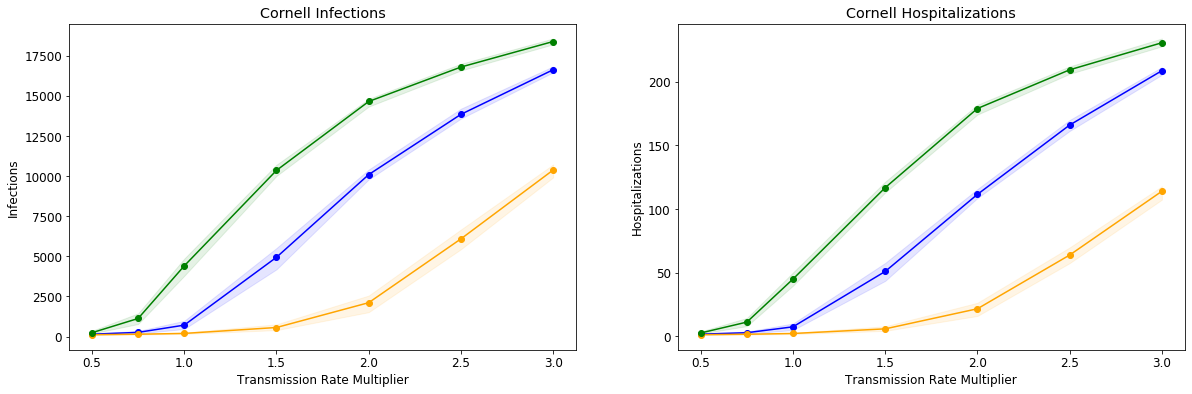

<Figure size 432x288 with 0 Axes>

In [160]:
f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))

plt.subplot(1, 2, 1)
plt.plot(plotting_data_TR_nominal_results[['TR_mult']], plotting_data_TR_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='TR_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_TR_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_TR_optimistic_results[['TR_mult']], plotting_data_TR_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='TR_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_TR_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_TR_pessimistic_results[['TR_mult']], plotting_data_TR_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='TR_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_TR_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Transmission Rate Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Scenarios')
# plt.ylim(0, 7000)

plt.subplot(1,2,2)
plt.plot(plotting_data_TR_nominal_results[['TR_mult']], plotting_data_TR_nominal_results[['cornell_hosp']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='TR_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_TR_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_TR_optimistic_results[['TR_mult']], plotting_data_TR_optimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='TR_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_TR_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_TR_pessimistic_results[['TR_mult']], plotting_data_TR_pessimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='green')
plt.fill_between(x='TR_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_TR_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Hospitalizations')
plt.ylabel('Hospitalizations')
plt.xlabel('Transmission Rate Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Scenarios')
# plt.ylim(0, 7000)
plt.show()

plt.savefig('res_inst_paper_graphs/sensitivity_transmission_rate.jpg', dpi=450)

### Cases found per contact trace

In [150]:
nominal_params_list, nominal_interaction_matrix, group_names = get_nominal_params()
nominal_params_list[0].keys()

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


dict_keys(['severity_prevalence', 'population_size', 'initial_ID_prevalence', 'max_time_ID', 'ID_time_function', 'max_time_SyID_mild', 'SyID_mild_time_function', 'max_time_SyID_severe', 'SyID_severe_time_function', 'max_time_exposed', 'exposed_time_function', 'exposed_infection_p', 'expected_contacts_per_day', 'daily_outside_infection_p', 'mild_symptoms_daily_self_report_p', 'severe_symptoms_daily_self_report_p', 'sample_QI_exit_function', 'sample_QS_exit_function', 'perform_contact_tracing', 'contact_tracing_delay', 'cases_isolated_per_contact', 'cases_quarantined_per_contact', 'use_asymptomatic_testing', 'contact_trace_testing_frac', 'days_between_tests', 'test_population_fraction', 'test_protocol_QFNR', 'test_protocol_QFPR', 'max_time_pre_ID', 'pre_ID_time_function', 'initial_E_count', 'initial_pre_ID_count', 'initial_ID_count', 'initial_SyID_mild_count', 'initial_SyID_severe_count', 'pre_ID_state', 'mild_severity_levels'])

In [151]:
CI_mult_list = [0.5, 0.75, 1, 1.5, 2, 2.5]

CI_nominal_results = list()
CI_optimistic_results = list()
CI_pessimistic_results = list()

testing_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

for CI_mult in CI_mult_list:
    print('Evaluating this mult: ', CI_mult)
    nominal_params_list, nominal_interaction_matrix, group_names = get_nominal_params()
    optimistic_params_list, optimistic_interaction_matrix, group_names = get_optimistic_params()
    pessimistic_params_list, pessimistic_interaction_matrix, group_names = get_pessimistic_params()
    for param_config in nominal_params_list:
        param_config['cases_isolated_per_contact'] *= CI_mult
    for param_config in optimistic_params_list:
        param_config['cases_isolated_per_contact'] *= CI_mult
    for param_config in pessimistic_params_list:
        param_config['cases_isolated_per_contact'] *= CI_mult

#     params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    nominal_tests_per_day, nominal_inf_matrix, nominal_hosp_matrix = evaluate_testing_policy(nominal_params_list, nominal_interaction_matrix, group_names, testing_policy, 112, 100)
    CI_nominal_results.append({'test_policy': policy, 'tests_per_day': nominal_tests_per_day, 'inf_matrix': nominal_inf_matrix, 'hosp_matrix': nominal_hosp_matrix})
    optimistic_tests_per_day, optimistic_inf_matrix, optimistic_hosp_matrix = evaluate_testing_policy(optimistic_params_list, optimistic_interaction_matrix, group_names, testing_policy, 112, 100)
    CI_optimistic_results.append({'test_policy': policy, 'tests_per_day': optimistic_tests_per_day, 'inf_matrix': optimistic_inf_matrix, 'hosp_matrix': optimistic_hosp_matrix})
    pessimistic_tests_per_day, pessimistic_inf_matrix, pessimistic_hosp_matrix = evaluate_testing_policy(pessimistic_params_list, pessimistic_interaction_matrix, group_names, testing_policy, 112, 100)
    CI_pessimistic_results.append({'test_policy': policy, 'tests_per_day': pessimistic_tests_per_day, 'inf_matrix': pessimistic_inf_matrix, 'hosp_matrix': pessimistic_hosp_matrix})


Evaluating this mult:  0.5
Evaluating this mult:  0.75
Evaluating this mult:  1
Evaluating this mult:  1.5
Evaluating this mult:  2
Evaluating this mult:  2.5


In [152]:
plotting_data_CI_nominal_results = generate_plotting_matrix(CI_nominal_results)
plotting_data_CI_nominal_results['CI_mult'] = CI_mult_list
plotting_data_CI_optimistic_results = generate_plotting_matrix(CI_optimistic_results)
plotting_data_CI_optimistic_results['CI_mult'] = CI_mult_list
plotting_data_CI_pessimistic_results = generate_plotting_matrix(CI_pessimistic_results)
plotting_data_CI_pessimistic_results['CI_mult'] = CI_mult_list


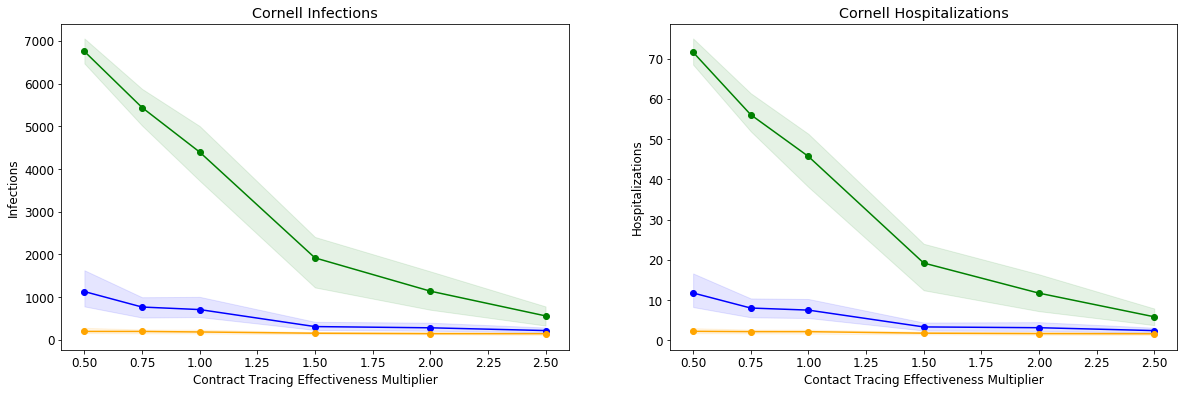

<Figure size 432x288 with 0 Axes>

In [161]:
f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))

plt.subplot(1, 2, 1)
plt.plot(plotting_data_CI_nominal_results[['CI_mult']], plotting_data_CI_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='CI_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_CI_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_CI_optimistic_results[['CI_mult']], plotting_data_CI_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='CI_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_CI_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_CI_pessimistic_results[['CI_mult']], plotting_data_CI_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='CI_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_CI_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Contract Tracing Effectiveness Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Scenarios')
# plt.ylim(0, 7000)

plt.subplot(1,2,2)
plt.plot(plotting_data_CI_nominal_results[['CI_mult']], plotting_data_CI_nominal_results[['cornell_hosp']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='CI_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_CI_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_CI_optimistic_results[['CI_mult']], plotting_data_CI_optimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='CI_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_CI_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_CI_pessimistic_results[['CI_mult']], plotting_data_CI_pessimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='green')
plt.fill_between(x='CI_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_CI_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Hospitalizations')
plt.ylabel('Hospitalizations')
plt.xlabel('Contact Tracing Effectiveness Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Scenarios')
# plt.ylim(0, 7000)
plt.show()

plt.savefig('res_inst_paper_graphs/sensitivity_contact_tracing_effectiveness.jpg', dpi=450)

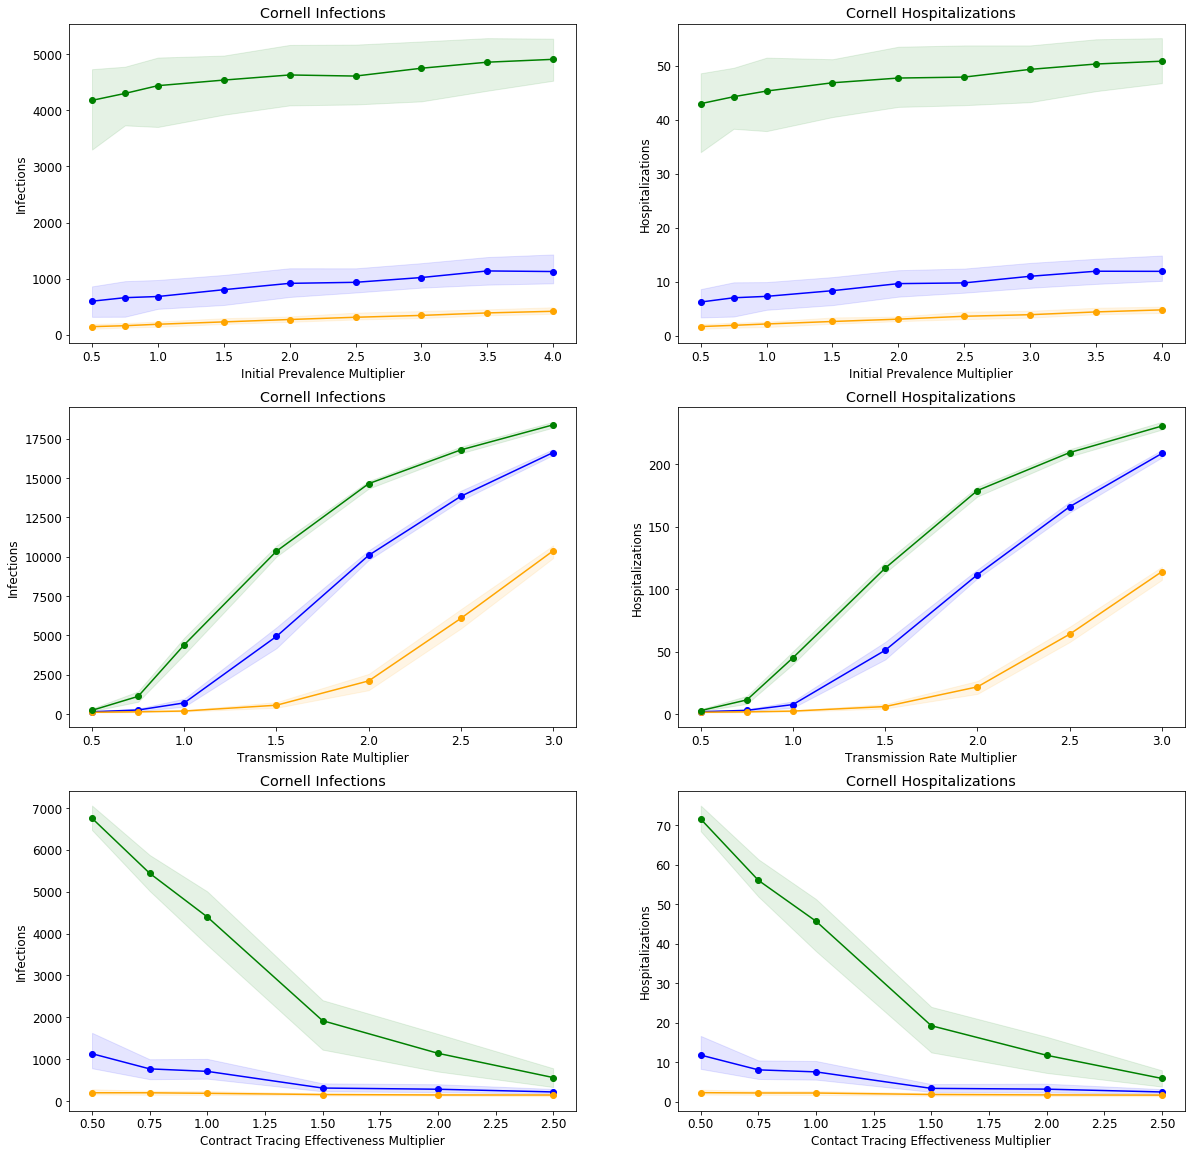

<Figure size 432x288 with 0 Axes>

In [164]:
f, axs = plt.subplots(3,2,sharex=False,figsize=(20,20))

plt.subplot(3, 2, 1)
plt.plot(plotting_data_nominal_results[['initial_prev_mult']], plotting_data_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='initial_prev_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_optimistic_results[['initial_prev_mult']], plotting_data_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='initial_prev_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_pessimistic_results[['initial_prev_mult']], plotting_data_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='initial_prev_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Initial Prevalence Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 7000)

plt.subplot(3,2,2)
plt.plot(plotting_data_nominal_results[['initial_prev_mult']], plotting_data_nominal_results[['cornell_hosp']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='initial_prev_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_optimistic_results[['initial_prev_mult']], plotting_data_optimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='initial_prev_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_pessimistic_results[['initial_prev_mult']], plotting_data_pessimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='green')
plt.fill_between(x='initial_prev_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Hospitalizations')
plt.ylabel('Hospitalizations')
plt.xlabel('Initial Prevalence Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 7000)

plt.subplot(3, 2, 3)
plt.plot(plotting_data_TR_nominal_results[['TR_mult']], plotting_data_TR_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='TR_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_TR_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_TR_optimistic_results[['TR_mult']], plotting_data_TR_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='TR_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_TR_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_TR_pessimistic_results[['TR_mult']], plotting_data_TR_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='TR_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_TR_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Transmission Rate Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 7000)

plt.subplot(3,2,4)
plt.plot(plotting_data_TR_nominal_results[['TR_mult']], plotting_data_TR_nominal_results[['cornell_hosp']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='TR_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_TR_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_TR_optimistic_results[['TR_mult']], plotting_data_TR_optimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='TR_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_TR_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_TR_pessimistic_results[['TR_mult']], plotting_data_TR_pessimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='green')
plt.fill_between(x='TR_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_TR_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Hospitalizations')
plt.ylabel('Hospitalizations')
plt.xlabel('Transmission Rate Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 7000)

plt.subplot(3, 2, 5)
plt.plot(plotting_data_CI_nominal_results[['CI_mult']], plotting_data_CI_nominal_results[['cornell_inf']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='CI_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_CI_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_CI_optimistic_results[['CI_mult']], plotting_data_CI_optimistic_results[['cornell_inf']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='CI_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_CI_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_CI_pessimistic_results[['CI_mult']], plotting_data_CI_pessimistic_results[['cornell_inf']], marker='o', label='Nominal', color='green')
plt.fill_between(x='CI_mult', y1='cornell_inf_low', y2='cornell_inf_high', data=plotting_data_CI_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Infections')
plt.ylabel('Infections')
plt.xlabel('Contract Tracing Effectiveness Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 7000)

plt.subplot(3,2,6)
plt.plot(plotting_data_CI_nominal_results[['CI_mult']], plotting_data_CI_nominal_results[['cornell_hosp']], marker='o', label='Nominal', color='blue')
plt.fill_between(x='CI_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_CI_nominal_results, alpha=0.1, color='blue')
plt.plot(plotting_data_CI_optimistic_results[['CI_mult']], plotting_data_CI_optimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='orange')
plt.fill_between(x='CI_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_CI_optimistic_results, alpha=0.1, color='orange')
plt.plot(plotting_data_CI_pessimistic_results[['CI_mult']], plotting_data_CI_pessimistic_results[['cornell_hosp']], marker='o', label='Nominal', color='green')
plt.fill_between(x='CI_mult', y1='cornell_hosp_low', y2='cornell_hosp_high', data=plotting_data_CI_pessimistic_results, alpha=0.1, color='green')
plt.title('Cornell Hospitalizations')
plt.ylabel('Hospitalizations')
plt.xlabel('Contact Tracing Effectiveness Multiplier')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0, 7000)
plt.show()

plt.savefig('res_inst_paper_graphs/sensitivity_combined.png', dpi=450)

# Figure 5 - Infections vs. Daily tests (pareto-efficient frontier)

In [118]:
def plot_policy_performance(plotting_data, selected_policy_index):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    plt.errorbar(x='daily_tests', y='inf', yerr = [plotting_data['inf_yerr_low'],plotting_data['inf_yerr_high']], fmt='o', data=plotting_data, label='baseline')
    plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['inf'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
    # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
    # text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
    # for index in range(len(text_x)):
    #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.title('Infections vs. Daily tests for various policies')
    plt.ylabel('Infections')
    plt.xlabel('Daily Tests')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.errorbar(x='daily_tests', y='hosp', yerr = [plotting_data['hosp_yerr_low'],plotting_data['hosp_yerr_high']], fmt='o', data=plotting_data, label='baseline')
    plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['hosp'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
    # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
    # text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
    # for index in range(len(text_x)):
    #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.title('Hospitalizations vs. Daily tests for various policies')
    plt.ylabel('Hospitalizations')
    plt.xlabel('Daily Tests')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.errorbar(x='daily_tests', y='cornell_inf', yerr = [plotting_data['cornell_inf_yerr_low'],plotting_data['cornell_inf_yerr_high']], fmt='o', data=plotting_data, label='baseline')
    plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['cornell_inf'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
    # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
    # text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
    # for index in range(len(text_x)):
    #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.title('Cornell Infections vs. Daily tests for various policies')
    plt.ylabel('Cornell Infections')
    plt.xlabel('Daily Tests')
    plt.legend()
    plt.show()


    plt.figure(figsize=(10,6))
    plt.errorbar(x='daily_tests', y='cornell_hosp', yerr = [plotting_data['cornell_hosp_yerr_low'],plotting_data['cornell_hosp_yerr_high']], fmt='o', data=plotting_data, label='baseline')
    plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['cornell_hosp'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
    # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
    # text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
    # for index in range(len(text_x)):
    #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.title('Cornell Hospitalizations vs. Daily tests for various policies')
    plt.ylabel('Cornell Hospitalizations')
    plt.xlabel('Daily Tests')
    plt.legend()
    plt.show()

In [119]:
np.random.seed(2025)
params_list, interaction_matrix, group_names = get_nominal_params()

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [120]:
limited_policies = [[1/7,1/7,1/7,1/7,1/7,1/7,1/14,0],
[2/7,1/7,1/7,1/7,1/7,1/7,1/30,0],
[2/7,2/7,1/7,1/7,1/7,1/7,1/30,0],
[2/7,1/7,2/7,1/7,1/7,1/7,1/30,0],
[2/7,1/7,1/7,2/7,1/7,1/7,1/30,0],
[2/7,1/7,1/7,1/7,2/7,1/7,1/30,0],
[2/7,1/7,1/7,1/7,1/7,2/7,1/30,0],
[2/7,2/7,1/7,2/7,1/7,1/7,1/30,0],
[2/7,2/7,2/7,1/7,2/7,1/7,1/30,0],
[2/7,2/7,1/7,2/7,2/7,1/7,1/30,0]]

In [121]:
results_baseline = list()

for policy in limited_policies:
    print('Evaluating this policy: ', policy)
#     params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 112, 100)
    results_baseline.append({'test_policy': policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857

In [122]:
plotting_data = generate_plotting_matrix(results_baseline)

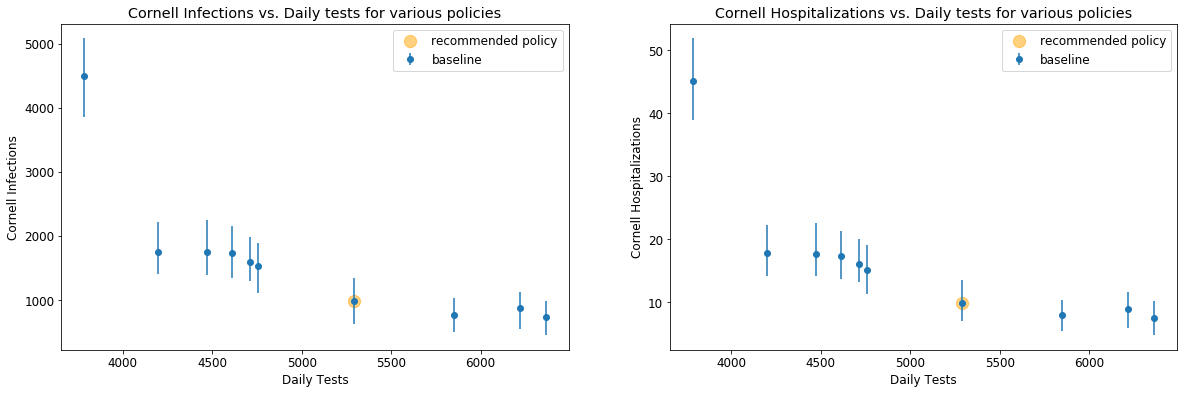

<Figure size 432x288 with 0 Axes>

In [167]:
selected_policy_index = 2

f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))

# plt.errorbar(x='daily_tests', y='inf', yerr = [plotting_data['inf_yerr_low'],plotting_data['inf_yerr_high']], fmt='o', data=plotting_data, label='baseline')
# plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['inf'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
# # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# # text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
# # for index in range(len(text_x)):
# #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
# plt.title('Infections vs. Daily tests for various policies')
# plt.ylabel('Infections')
# plt.xlabel('Daily Tests')
# plt.legend()

# plt.errorbar(x='daily_tests', y='hosp', yerr = [plotting_data['hosp_yerr_low'],plotting_data['hosp_yerr_high']], fmt='o', data=plotting_data, label='baseline')
# plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['hosp'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
# # text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# # text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
# # for index in range(len(text_x)):
# #     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
# plt.title('Hospitalizations vs. Daily tests for various policies')
# plt.ylabel('Hospitalizations')
# plt.xlabel('Daily Tests')
# plt.legend()
# plt.show()

plt.subplot(1,2,1)
plt.errorbar(x='daily_tests', y='cornell_inf', yerr = [plotting_data['cornell_inf_yerr_low'],plotting_data['cornell_inf_yerr_high']], fmt='o', data=plotting_data, label='baseline')
plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['cornell_inf'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Cornell Infections vs. Daily tests for various policies')
plt.ylabel('Cornell Infections')
plt.xlabel('Daily Tests')
plt.legend()


plt.subplot(1,2,2)
plt.errorbar(x='daily_tests', y='cornell_hosp', yerr = [plotting_data['cornell_hosp_yerr_low'],plotting_data['cornell_hosp_yerr_high']], fmt='o', data=plotting_data, label='baseline')
plt.scatter(x=plotting_data['daily_tests'][selected_policy_index], y=plotting_data['cornell_hosp'][selected_policy_index],c='orange',s=150,alpha=0.5, label='recommended policy')
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Cornell Hospitalizations vs. Daily tests for various policies')
plt.ylabel('Cornell Hospitalizations')
plt.xlabel('Daily Tests')
plt.legend()
plt.show()

plt.savefig('res_inst_paper_graphs/testing_policy.png', dpi=450)

In [ ]:
# plot_policy_performance(plotting_data, 2)
# plt.savefig('res_inst_paper_graphs/sensitivity_transmission_rate.jpg', dpi=450)

# Figure 6 - Contour plot (mult of transmission rate, daily test %) split by inf, hosp

In [9]:
X_TR = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 5]
Y_test_freq = [0.5, 0.75, 1, 1.25, 1.5, 2, 3, 4, 5]

Zs_hosp = list()
Zs_inf = list()
Zs_cornell_hosp = list()
Zs_cornell_inf = list()
for TR in X_TR:
    
    Z_hosp = list()
    Z_inf = list()
    Z_cornell_hosp = list()
    Z_cornell_inf = list()
    for test_freq in Y_test_freq:
        params_list, interaction_matrix, group_names = get_nominal_params()
#for (contacts, popsize), dfs in sensitivity_output.sim_results['Nominal Student Parameters'].items():
        testing_policy = np.array([2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]) * test_freq
        interaction_matrix *= TR
#         virtual_normal = list()
        
        print('Evaluating this: ', TR, test_freq)
        tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 25)
#         virtual_normal.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})
        
        Z_hosp.append(np.quantile(np.sum(hosp_matrix, axis=1), 0.5))
        Z_inf.append(np.quantile(np.sum(inf_matrix, axis=1), 0.5))
        Z_cornell_hosp.append(np.quantile(np.sum(np.array(hosp_matrix)[:,:-1],axis=1), 0.5))
        Z_cornell_inf.append(np.quantile(np.sum(np.array(inf_matrix)[:,:-1],axis=1), 0.5))

    Zs_hosp.append(Z_hosp)
    Zs_inf.append(Z_inf)
    Zs_cornell_hosp.append(Z_cornell_hosp)
    Zs_cornell_inf.append(Z_cornell_inf)

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Evaluating this:  0.5 0.5
Evaluating this:  0.5 0.75
Evaluating this:  0.5 1
Evaluating this:  0.5 1.25
Evaluating this:  0.5 2
Evaluating this:  0.5 3
Evaluating this:  0.5 4
Evaluating this:  0.5 5
Evaluating this:  0.75 0.5
Evaluating this:  0.75 0.75
Evaluating this:  0.75 1
Evaluating this:  0.75 1.25
Evaluating this:  0.75 1.5
Evaluating this:  0.75 2
Evaluating this:  0.75 3
Evaluating this:  0.75 4
Evaluating this:  0.75 5
Evaluating this:  1 0.5
Evaluating this:  1 0.75
Evaluating this:  1 1
Evaluating this:  1 1.25
Evaluating this:  1 1.5
Evaluating this:  1 2
Evaluating this:  1 3
Evaluating this:  1 4
Evaluating this:  1 5
Evaluating this:  1.25 0.5
Evaluating this:  1.25 0.75
Evaluating this:  1.25 1
Evaluating this:  1.25 1.25
Evaluating this:  1.25 1.5
Evaluating this:  1.25 2
Evaluating this:  1.25 3
Evaluating this:  1.25 4
Evaluating this:  1.25 5
Evaluating this:  1.5 0.5
Evaluating this:  1.5 0.75
Evaluating this:  1.5 1
Evaluating this:  1.5 1.25
Evaluating this:  

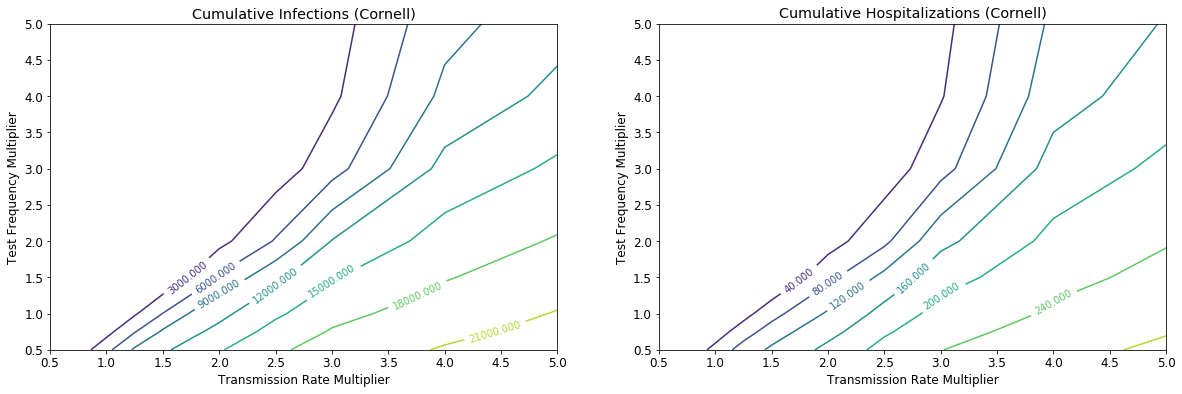

In [10]:
f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))


# inf_levels = [0.025, 0.05, 0.1, 0.2, 0.3, 0.5]
# inf_labels = dict()
# for level in inf_levels:
#     inf_labels[level] = str(level*100) + '%'
    
plt.subplot(1,2,1)
plt.title("Cumulative Infections (Cornell)")
plt.ylabel("Test Frequency Multiplier")
plt.xlabel("Transmission Rate Multiplier")
CS = plt.contour(np.array(X_TR), np.array(Y_test_freq), np.array(Zs_cornell_inf).T)
# CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_inf).T/34310, inf_levels)
# plt.clabel(CS, fmt=inf_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)


plt.subplot(1,2,2)
plt.title("Cumulative Hospitalizations (Cornell)")
plt.ylabel("Test Frequency Multiplier")
plt.xlabel("Transmission Rate Multiplier")
CS = plt.contour(np.array(X_TR), np.array(Y_test_freq), np.array(Zs_cornell_hosp).T)
# pop_levels = [0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005]
# pop_labels = dict()
# for level in pop_levels:
#     pop_labels[level] = str(level*100) + '%'
# CS = plt.contour(np.array(X_popsize), np.array(Y_testfrac) * 100, np.array(Zs_hosp).T/34310, pop_levels)
# plt.clabel(CS, fmt=pop_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)
plt.show()


# plt.savefig('res_inst_paper_graphs/test_freq_tr_mult_contour.png', dpi=450)

# Figure 7 - Shutdown policies